In [1]:
# Importing packages
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate,Subtract,Multiply,Concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation,MaxPooling2D,Bidirectional,Flatten,Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, ConfusionMatrixDisplay
import spacy
sp = spacy.load('en_core_web_sm')
# import nltk
# nltk.download("punkt")

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Read Dataset

In [3]:
project_path = '/content/drive/Shareddrives/ProgettoAI_NLP/'

In [4]:
data = pd.read_csv(project_path+"cleaned.csv",na_filter=False)
data.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,0,0,1,2,what be the step by step guide to invest in sh...,what be the step by step guide to invest in sh...,0
1,1,1,3,4,what be the story of kohinoor koh noor diamond,what would happen if the indian government ste...,0
2,2,2,5,6,how can increase the speed of my internet conn...,how can internet speed be increase by hack thr...,0
3,3,3,7,8,why be mentally very lonely how can solve it,find the remainder when be divide by,0
4,4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


## Preprocess Data

In [5]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
def clean_question(text):
    doc = sp(text)
    # tokenize
    # text = text.split()
    # Lemmatization
    text = [token.lemma_ for token in doc]
    # convert to lower case
    text = [word.lower() for word in text]
    # remove punctuation from each token
    text = [w.translate(table) for w in text]
    # remove hanging 's' and 'a'
    text = [word for word in text if len(word)>1]
    # remove tokens with numbers in them
    text = [word for word in text if word.isalpha()]
    # store as string
    return ' '.join(text)

## Feature Extraction

In [7]:
# fit a tokenizer with questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["question1"].values+data["question2"].values)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 150804


In [8]:
# create sequences
max_len = 25
q1_texts_seq = tokenizer.texts_to_sequences(data["question1"].values)
q2_texts_seq = tokenizer.texts_to_sequences(data["question2"].values)

q1_texts_seq = pad_sequences(q1_texts_seq,maxlen=max_len)
q2_texts_seq = pad_sequences(q2_texts_seq,maxlen=max_len)

In [9]:
if os.path.isdir('glove') == False:
    os.mkdir('glove')

glove_dir = "datasets/"
from zipfile import ZipFile
with ZipFile(project_path+'glove.zip', 'r') as z:
  z.extractall("glove")

In [10]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open(os.path.join("glove/", 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [11]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [12]:
X = np.stack((q1_texts_seq, q2_texts_seq), axis=1)
y = data["is_duplicate"].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Get Question 1/2  train and test features
q1_X_train = X_train[:,0]
q2_X_train = X_train[:,1]

q1_X_test = X_test[:,0]
q2_X_test = X_test[:,1]

## Build Model

Paraphrase Detection using **Siamese Network** model

In [15]:
## Define custon metrics
def f1_score(y_true, y_pred):
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0 or c2 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / (c2 + K.epsilon())

    # How many relevant items are selected?
    recall = c1 / (c3 + K.epsilon())

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score


def precision(y_true, y_pred):
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    if c2 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / (c2 + K.epsilon())

    return precision


def recall(y_true, y_pred):
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many relevant items are selected?
    recall = c1 / (c3 + K.epsilon())

    return recall

In [16]:
from keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [28]:
from sklearn.metrics import roc_auc_score
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [29]:
# siamese model
def create_model(input_shape,embeddings_dim, embeddings_matrix, vocab_size,
                      max_seq_length, trainable_embeddings,
                      lstm_hidden_units):
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)


    common_embed = Embedding(vocab_size, embeddings_dim, weights=[embeddings_matrix], input_length=max_seq_length, trainable=trainable_embeddings)
    lstm_1 = common_embed(input_1)
    lstm_2 = common_embed(input_2)


    common_lstm = LSTM(lstm_hidden_units,return_sequences=True, activation="relu")
    vector_1 = common_lstm(lstm_1)
    vector_1 = Flatten()(vector_1)

    vector_2 = common_lstm(lstm_2)
    vector_2 = Flatten()(vector_2)

    x3 = Subtract()([vector_1, vector_2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([vector_1, vector_1])
    x2_ = Multiply()([vector_2, vector_2])
    x4 = Subtract()([x1_, x2_])

    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

    conc = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu", name='conc_layer')(conc)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid", name = 'out')(x)

    model = Model([input_1, input_2], out)
    optimizer = optimizers.Adam()
    model.compile(optimizer=optimizer,
                loss="binary_crossentropy",
                metrics=['accuracy'])

    return model

In [30]:
trainable_embeddings = False
lstm_hidden_units = 50
input_shape = (max_len,)
model = create_model(input_shape,
                      embedding_dim, embedding_matrix, vocab_size,
                      max_len, trainable_embeddings,lstm_hidden_units)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 25, 200)              3016080   ['input_3[0][0]',             
                                                          0          'input_4[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, 25, 50)               50200     ['embedding_1[0][0]',   

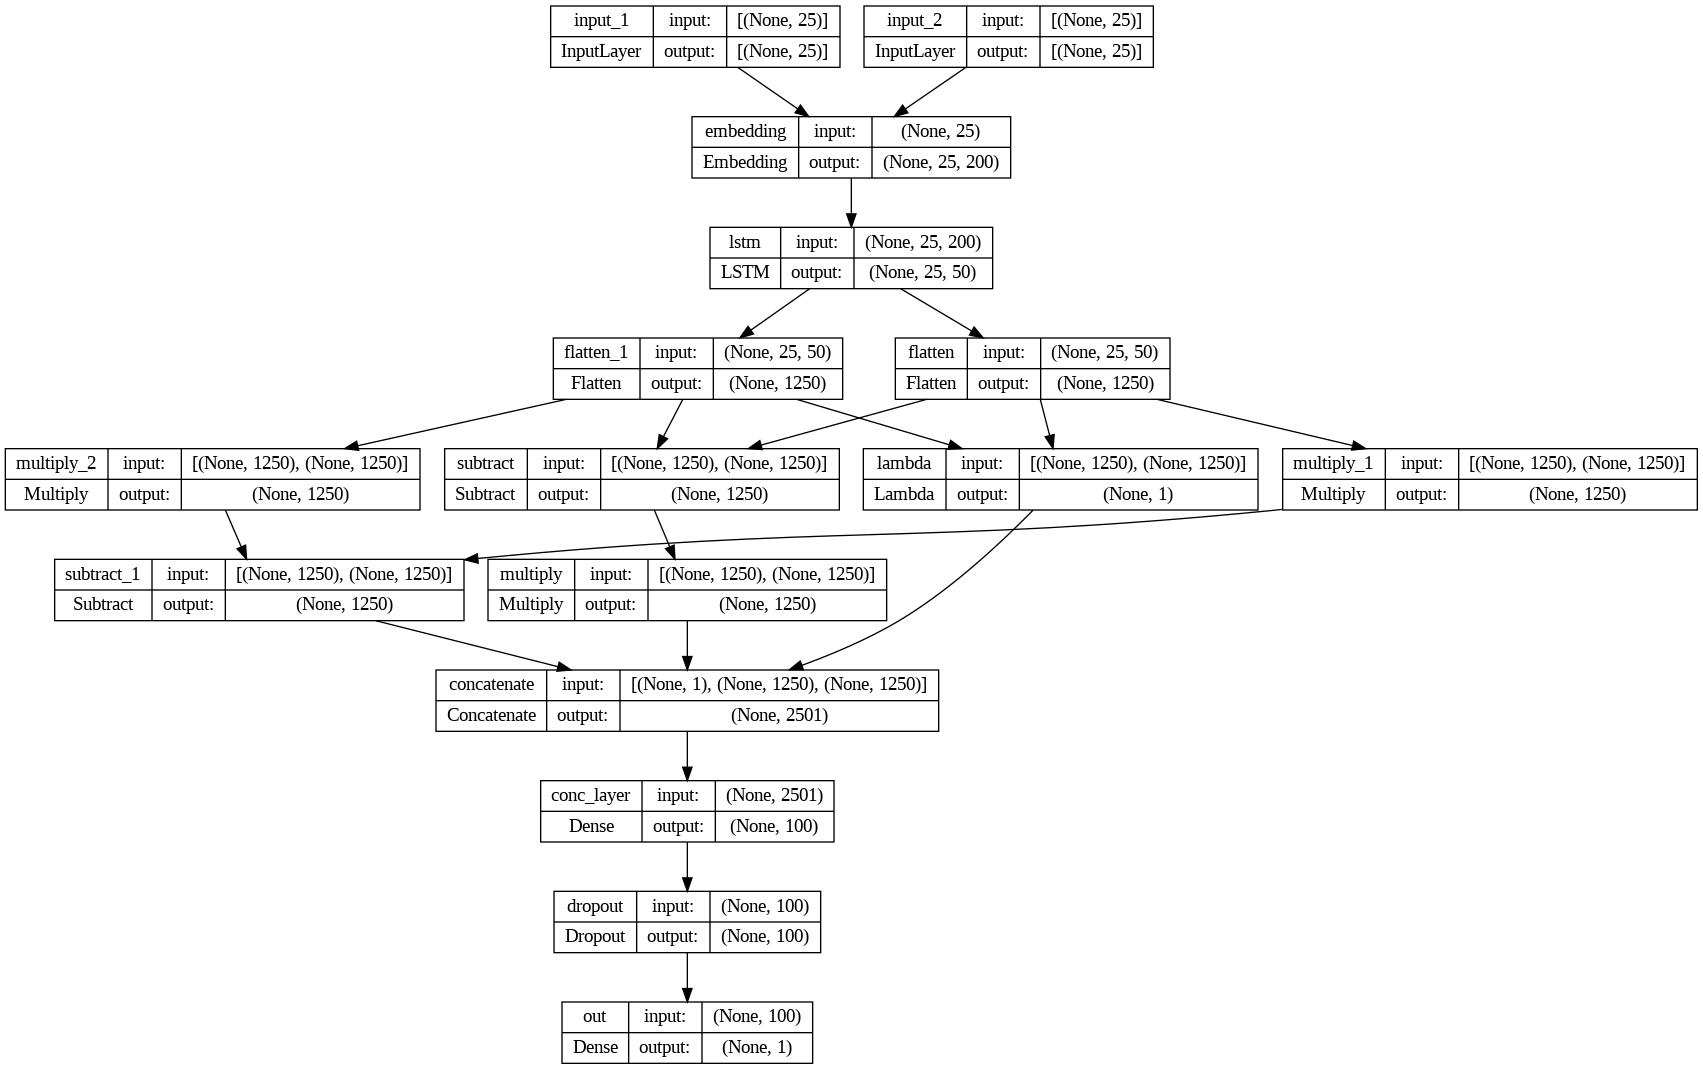

In [20]:
plot_model(model, to_file='model.png', show_shapes=True)

## Train the model

In [21]:
# Defining a helper function to save the model after each epoch
# in which the loss decreases
filepath = project_path+'model_paraprase_detection_siamese.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Defining a helper function to reduce the learning rate each time
# the learning plateaus
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
# stop traning if there increase in loss
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
callbacks = [checkpoint,reduce_alpha]

In [22]:
assd1=to_categorical(y_train)
assd2=y_train.astype(np.float32).reshape((-1,1))

print(assd1.shape,repr(assd1))
print(assd2.shape,repr(assd2))

(323480, 2) array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)
(323480, 1) array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)


In [25]:
!nvidia-smi

Mon Jan  8 14:57:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0              28W /  70W |    639MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [26]:
!sudo apt install neofetch
!neofetch

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  caca-utils chafa fonts-droid-fallback fonts-noto-mono fonts-urw-base35
  ghostscript gsfonts imagemagick imagemagick-6-common imagemagick-6.q16 jp2a
  libchafa0 libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9
  libgs9-common libid3tag0 libidn12 libijs-0.35 libimlib2 libjbig2dec0
  libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libpci3
  libsixel-bin libsixel1 libwmflite-0.2-7 netpbm pci.ids pciutils poppler-data
  toilet toilet-fonts w3m w3m-img
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng enscript gimp
  gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance sane-utils
  texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev inkscape
 

In [ ]:
epochs = 10
batch_size = 64
history = model.fit(x=[q1_X_train, q2_X_train],
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=([q1_X_test, q2_X_test],y_test),callbacks=callbacks)

Epoch 1/10
5055/5055 [==============================] - ETA: 0s - loss: 0.4705 - accuracy: 0.7669
Epoch 1: val_loss improved from inf to 0.43200, saving model to /content/drive/Shareddrives/ProgettoAI_NLP/model_paraprase_detection_siamese.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5055/5055 [==============================] - 355s 70ms/step - loss: 0.4705 - accuracy: 0.7669 - val_loss: 0.4320 - val_accuracy: 0.7936 - lr: 0.0010
Epoch 2/10
5055/5055 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.8107
Epoch 2: val_loss improved from 0.43200 to 0.40279, saving model to /content/drive/Shareddrives/ProgettoAI_NLP/model_paraprase_detection_siamese.h5
5055/5055 [==============================] - 354s 70ms/step - loss: 0.4008 - accuracy: 0.8107 - val_loss: 0.4028 - val_accuracy: 0.8105 - lr: 0.0010
Epoch 3/10
5055/5055 [==============================] - ETA: 0s - loss: 0.3689 - accuracy: 0.8285
Epoch 3: val_loss improved from 0.40279 to 0.39666, saving model to /content/drive/Shareddrives/ProgettoAI_NLP/model_paraprase_detection_siamese.h5
5055/5055 [==============================] - 352s 70ms/step - loss: 0.3689 - accuracy: 0.8285 - val_loss: 0.3967 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 4/10
5055/5055 [==============================] - ETA: 

In [ ]:
filepath = project_path+'model_paraprase_detection_siamese.h5'
model.save_weights(filepath)

## Training Summary

All data in history:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
Evaluation (loss, acc)
2528/2528 [==============================] - 34s 13ms/step - loss: 0.4907 - accuracy: 0.8207
loss: 0.4907   acc: 0.8207
2528/2528 [==============================] - 33s 13ms/step
f1: 0.0000
confusion matrix


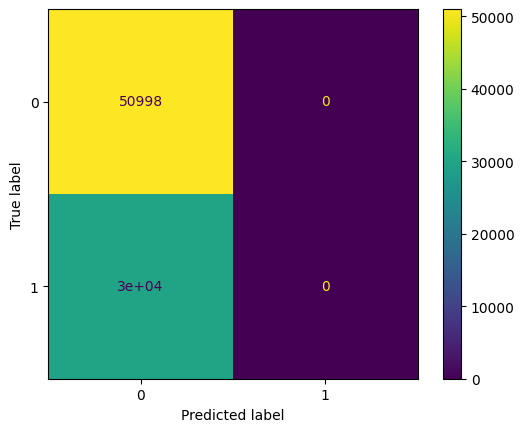

In [ ]:
# list all data in history
print("All data in history: ", history.history.keys())
print("Evaluation (loss, acc)")
loss, acc = model.evaluate(x=[q1_X_test, q2_X_test], y=y_test.astype(np.float32))
print("loss: {:.4f}   acc: {:.4f}".format(loss, acc))
pred = np.argmax(model.predict(x=[q1_X_test, q2_X_test]), axis=1)
f1 = f1_score(y_test, pred)
print("f1: {:.4f}".format(f1))
print("confusion matrix")
cf_mat = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat)
disp.plot()
plt.show()

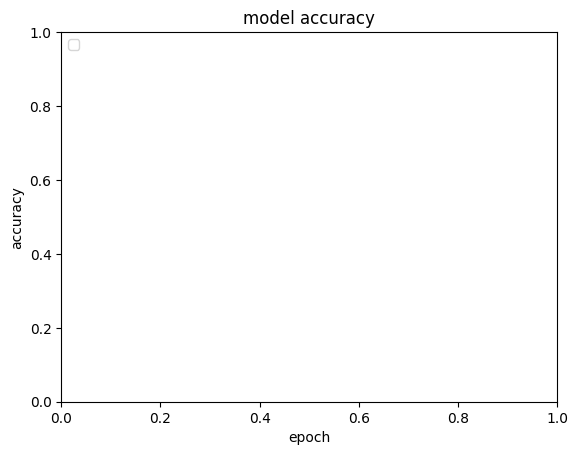

In [ ]:
# summarize history for accuracy
fig = plt.figure()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_accuracy.png')

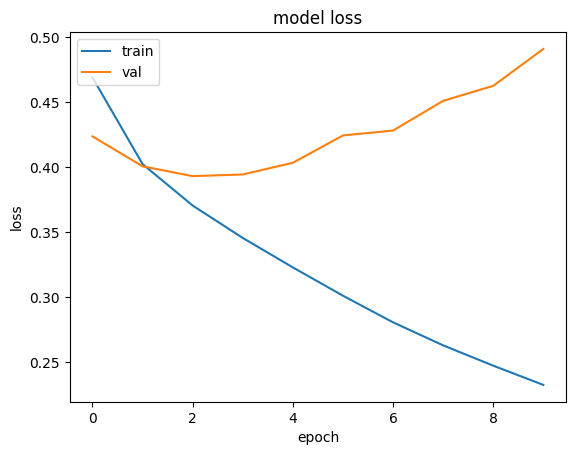

In [ ]:
# summarize history for loss
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_loss.png')

In [ ]:
# summarize history for precision
fig = plt.figure()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_precision.png')

In [ ]:
# summarize history for recall
fig = plt.figure()
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_recall.png')

KeyError: 'recall'

<Figure size 640x480 with 0 Axes>

In [ ]:
# summarize history for f1 score
fig = plt.figure()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig('model_f1_score.png')

## Test the model

In [ ]:
print('Testing Data Metrics:')
loss, accuracy, auroc, precision, recall, f1_score = model.evaluate([q1_X_test, q2_X_test], y_test)
print('')
print('loss      = {0:.4f}'.format(loss))
print('accuracy  = {0:.4f}'.format(accuracy))
print('auroc  = {0:.4f}'.format(auroc))
print('precision = {0:.4f}'.format(precision))
print('recall    = {0:.4f}'.format(recall))
print('F1         = {0:.4f}'.format(f1_score))